In [61]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import load_model


import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from common import *

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

numpy ver.: 1.13.1
pandas ver.: 0.19.0
tensorflow ver.: 1.0.0
keras ver.: 2.0.8


In [201]:
data = prep_data('../data/4A_1_201701_201708.csv')
print(len(data))

1769626


In [202]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 30)]
assert len(data['LinkRef'].unique()) == 30
n = len(data)
print(n)

1288980


In [203]:
data_train = data[:int(.95 * n)]
data_test = data[int(.95 * n):]
n_train = len(data_train)
n_test = len(data_test)
print(n_train, n_test)

(1224531, 64449)


In [204]:
(means, scales, low, upr) = fit_scale(data_train, smooth = 1)
assert means.shape[0] == 4 * 24 * 7
assert len(scales) == 30
assert len(low) == 30
assert len(upr) == 30
(means.shape, len(scales), len(low), len(upr))

((672, 30), 30, 30, 30)

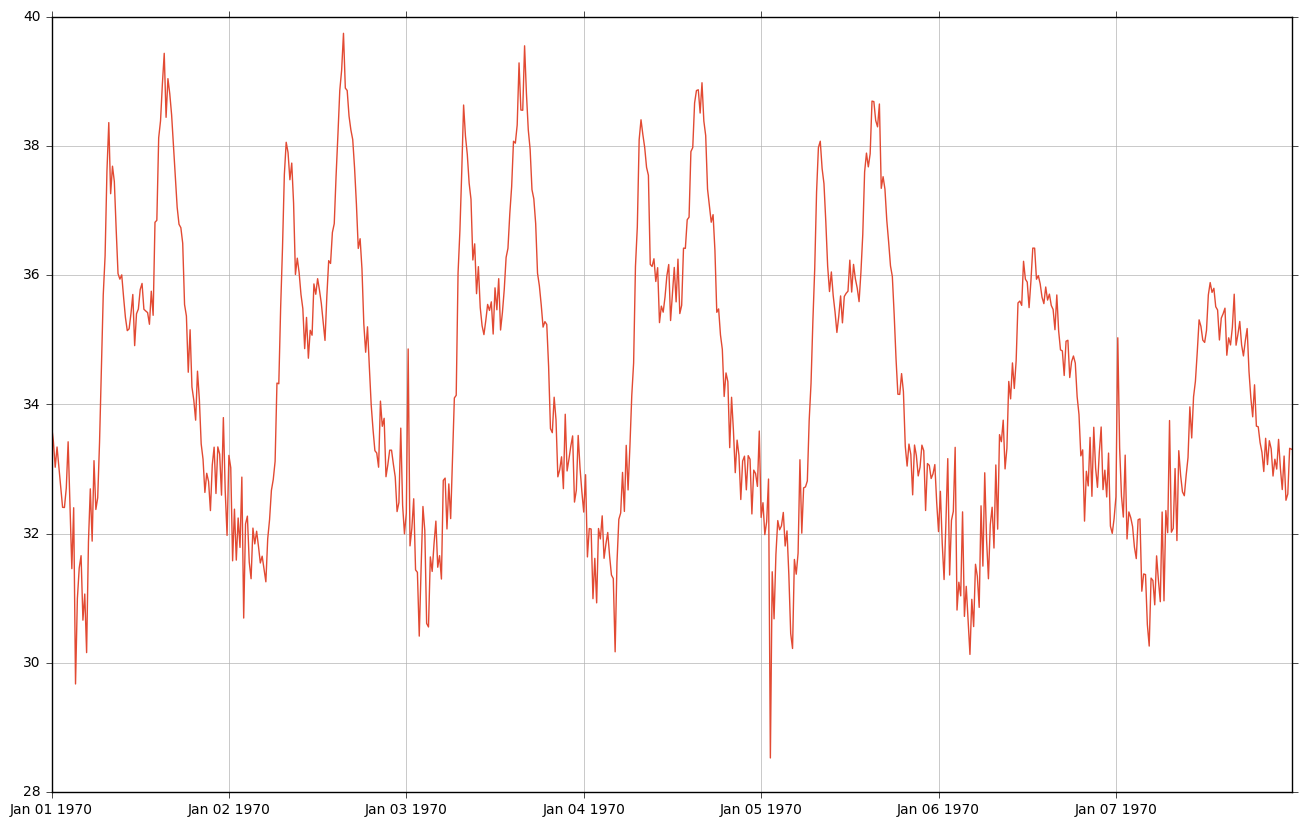

In [205]:
plt.plot(means.sum(axis = 1) / 60)

In [206]:
data_train_no, n = remove_outliers(data_train, low, upr)
print('Removed {0} outliers ({1:.3f}%)'.format(n, 1.0 * n / len(data_train)))

Removed 158737 outliers (0.130%)


In [209]:
data_test_no, n = remove_outliers(data_test, low, upr)
print('Removed {0} outliers ({1:.3f}%)'.format(n, 1.0 * n / len(data_test)))

Removed 9238 outliers (0.143%)


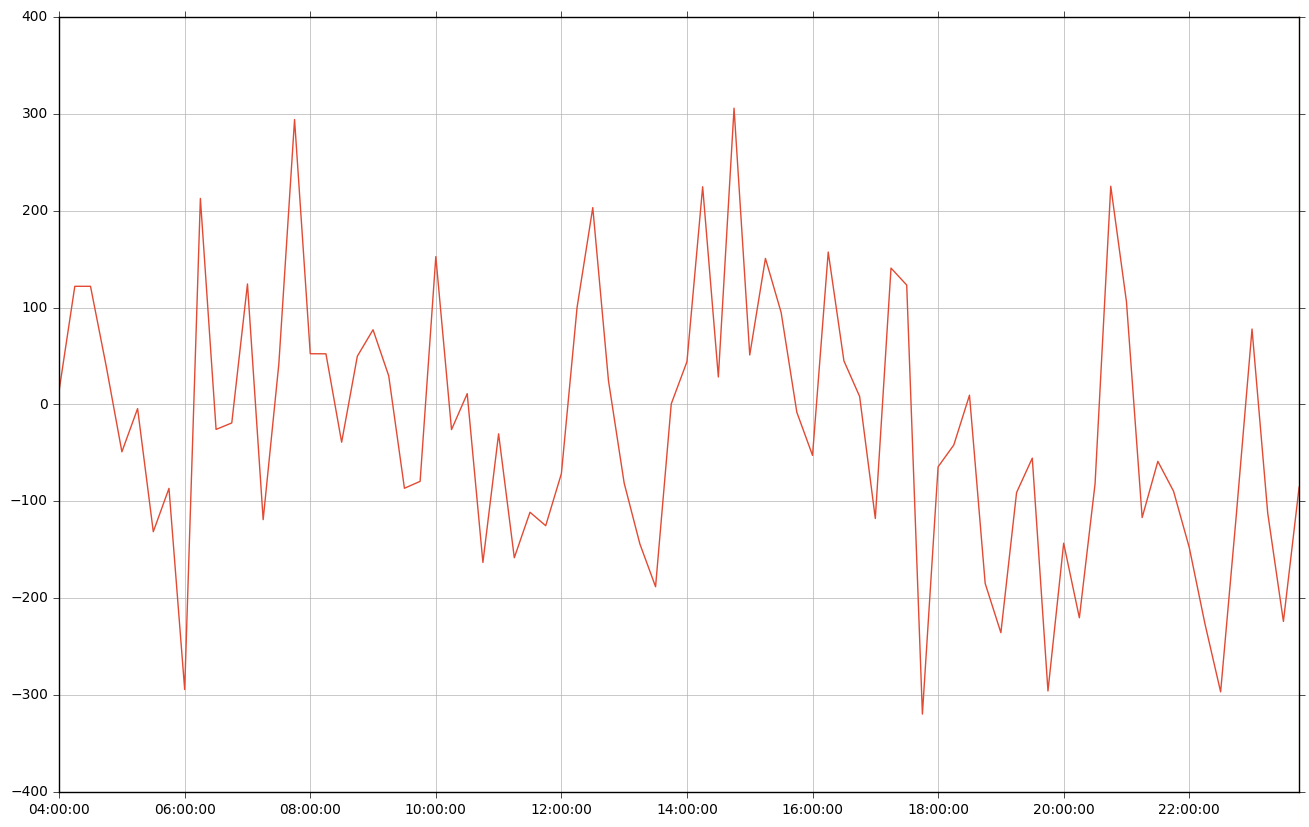

In [212]:
idx = ('2017-08-21 04:00' <= ix) & (ix < '2017-08-22 00:00')
plt.plot(ix[idx], ts[idx, ].sum(axis = 1))

In [213]:
 def roll(ix, ts, removed_mean, removed_scale, w, lags, preds):
    X = np.stack([np.roll(ts, i, axis = 0) for i in range(lags, 0, -1)], axis = 1)[lags:-preds,]
    Y = np.stack([np.roll(ts, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    Y_ix = ix[lags:-preds]
    Y_mean = np.stack([np.roll(removed_mean, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    Y_scale = np.stack([np.roll(removed_scale, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]
    w_y = np.stack([np.roll(w, -i, axis = 0) for i in range(0, preds, 1)], axis = 1)[lags:-preds,]

    return X, Y, Y_ix, Y_mean, Y_scale, w_y

In [214]:
X_test, Y_test, Y_test_ix, Y_test_mean, Y_test_scale, W_test = roll(ix, ts, removed_mean, removed_scale, w, 3, 1)
(X_test.shape, Y_test.shape)

((1112, 3, 30), (1112, 1, 30))

In [313]:
ix, ts, removed_mean, removed_scale, w, ks = transform(data_train_no, means, scales, low, upr, freq = '15min')
X_train, Y_train, Y_train_ix, Y_train_mean, Y_train_scale, W_train = roll(ix, ts, removed_mean, removed_scale, w, 3, 1)
(X_train.shape, Y_train.shape)

((22208, 3, 30), (22208, 1, 30))

In [365]:
from keras.layers import Input, Dense, Add, Permute, Flatten, Reshape
from keras.models import Model

outdim = np.array(Y_test.shape[1:]).prod()
# This returns a tensor
input_main = Input(shape=(X_test.shape[1:]), name = "main")
input_lag_error = Input(shape=Y_test.shape[1:], name = "lag_error")
f1 = Flatten(name = "flattern_main")(input_main)
f2 = Flatten(name = "flattern_lag_error")(input_lag_error)
x1 = Dense(outdim, name = "linear")(f1)
x2 = Dense(outdim, use_bias = False, name = "error")(f2)
add = Add(name = "output")([x1, x2])
out = Reshape(Y_test.shape[1:], name = 'reshape')(add)
model = keras.models.Model(inputs=[input_main, input_lag_error], outputs=out)
model.compile(loss = 'mse', optimizer = 'rmsprop')

In [366]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main (InputLayer)                (None, 3, 30)         0                                            
____________________________________________________________________________________________________
lag_error (InputLayer)           (None, 1, 30)         0                                            
____________________________________________________________________________________________________
flattern_main (Flatten)          (None, 90)            0           main[0][0]                       
____________________________________________________________________________________________________
flattern_lag_error (Flatten)     (None, 30)            0           lag_error[0][0]                  
___________________________________________________________________________________________

In [368]:
lag_error = np.zeros_like(Y_train)

for i in range(1, X_train.shape[0]):
    model.fit([X_train[i:i+1], lag_error[i-1:i]], Y_train[i:i+1], verbose = 0)
    pred = model.predict([X_train[i:i+1], lag_error[i-1:i]])
    error = Y_train[i:i+1] - pred
    lag_error[i] = error

rmse_sar = np.sqrt(np.mean(((W_train * lag_error / 60.0).sum(axis = 2))**2))
rmse_ha = np.sqrt(np.mean(((W_train * Y_train / 60.0).sum(axis = 2))**2))
print('rmse_sar  :', rmse_sar)
print('rmse_ha   :', rmse_ha)

('rmse_sar  :', 2.8651217073723498)
('rmse_ha   :', 4.11097475136794)


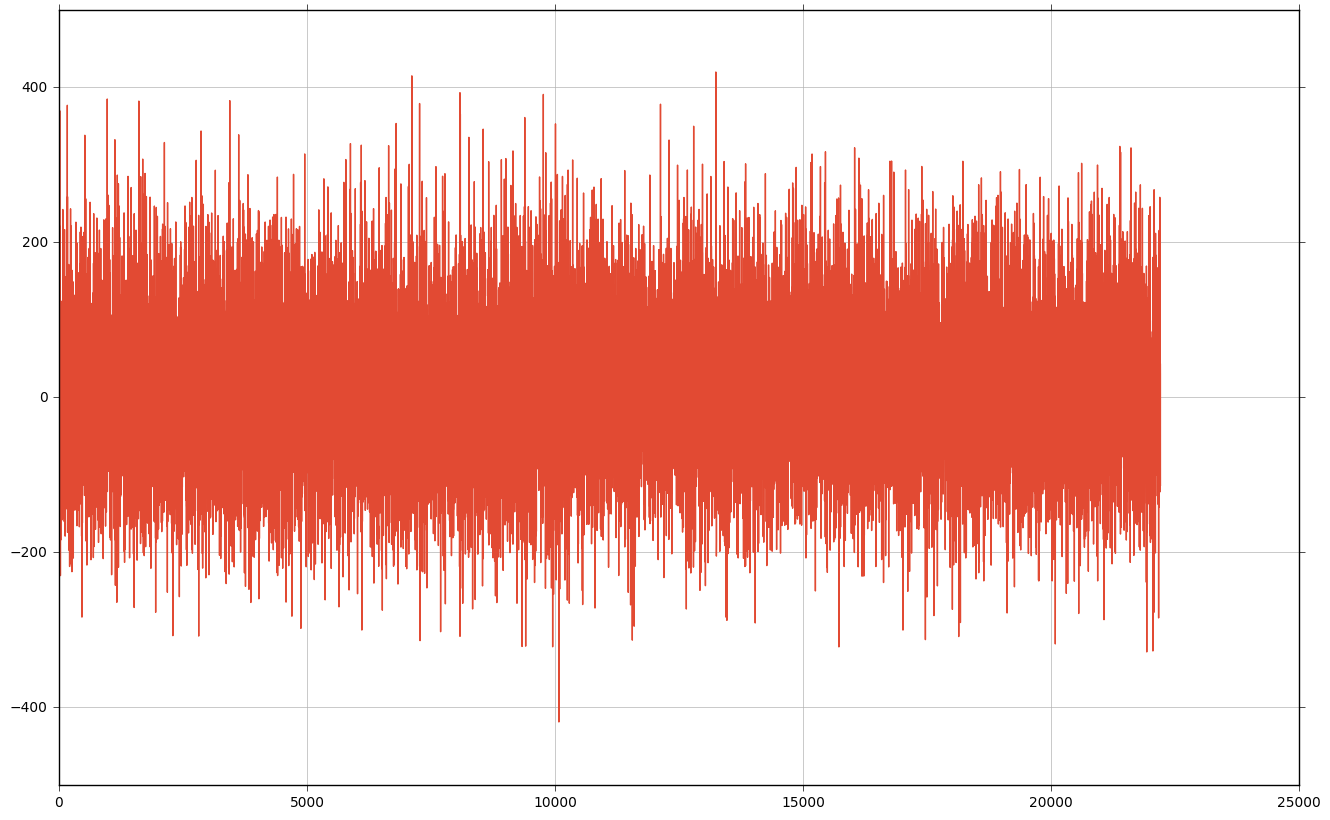

In [364]:
plt.plot(lag_error.sum(axis = 2))

In [351]:
lag_error = np.zeros(30)[np.newaxis,np.newaxis,]
preds = []
for i in range(X_test.shape[0]):
    pred = model.predict([X_test[i:i+1], lag_error[i:i+1]])
    error = Y_train[i:i+1] - pred
    lag_error = np.concatenate((lag_error, error), axis = 0)
    preds.append(pred)
    
    
rmse_sar = np.sqrt(np.mean(((W_test * lag_error[1:,] / 60.0).sum(axis = 2))**2))
rmse_ha = np.sqrt(np.mean(((W_test * Y_test / 60.0).sum(axis = 2))**2))
print('rmse_sar  :', rmse_sar)
print('rmse_ha   :', rmse_ha)

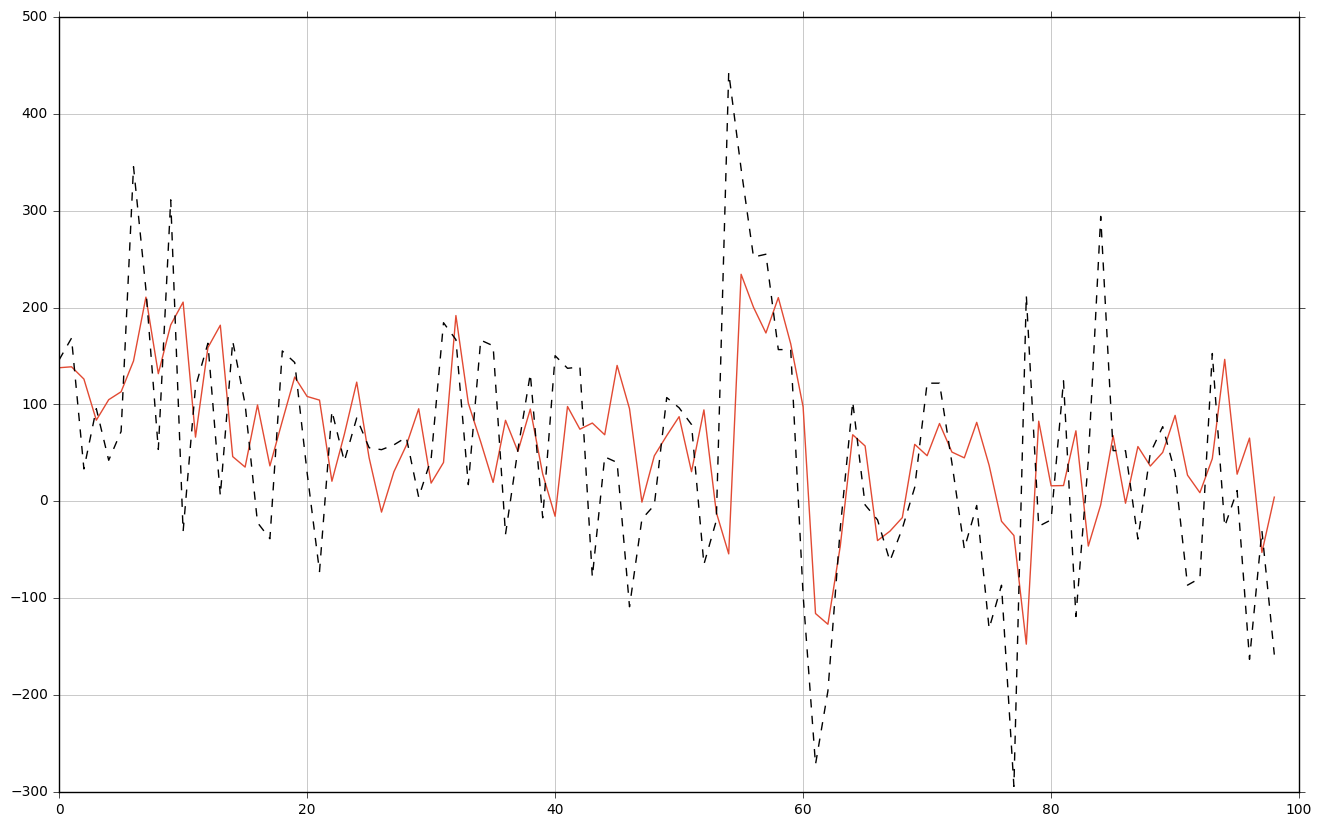

In [350]:
plt.plot(np.array(preds).squeeze().sum(axis = 1)[1:100])
plt.plot(np.array(Y_test).squeeze().sum(axis = 1)[1:100], color = 'k', linestyle = '--')